100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.82MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.50MB/s]


Total training samples: 60000
Total test samples: 10000
Client 1 dataset size: 6000
Client 2 dataset size: 6000
Client 3 dataset size: 6000
Client 4 dataset size: 6000
Client 5 dataset size: 6000
Client 6 dataset size: 6000
Client 7 dataset size: 6000
Client 8 dataset size: 6000
Client 9 dataset size: 6000
Client 10 dataset size: 6000
--- Round 1 ---
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4
Training on Client 5
Training on Client 6
Training on Client 7
Training on Client 8
Training on Client 9
Training on Client 10
Global Model Test Accuracy: 90.44%
--- Round 2 ---
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4
Training on Client 5
Training on Client 6
Training on Client 7
Training on Client 8
Training on Client 9
Training on Client 10
Global Model Test Accuracy: 98.15%
--- Round 3 ---
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4
Training on Client 5
Training on Client

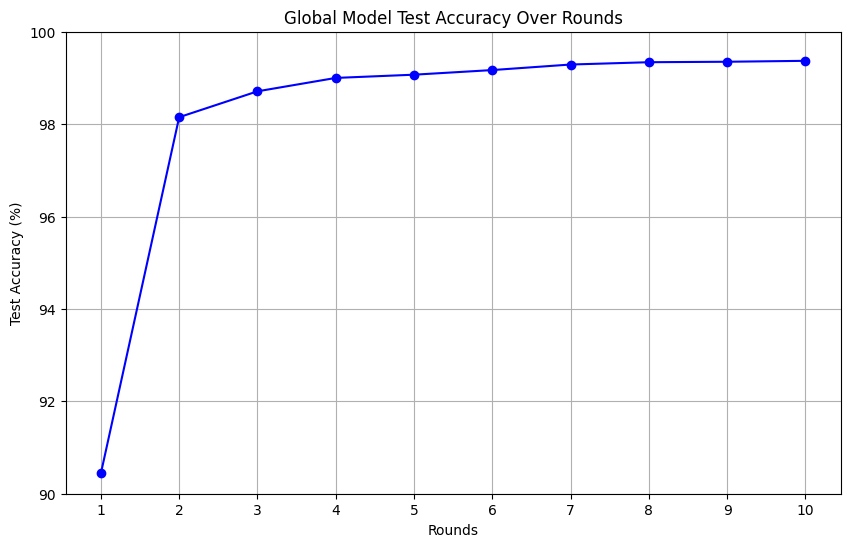

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_data(transform_train, transform_test, dataset_name='MNIST'):
    if dataset_name == 'MNIST':
        train_dataset = datasets.MNIST(
            root="./data/mnist", train=True, download=True, transform=transform_train)
        test_dataset = datasets.MNIST(
            root="./data/mnist", train=False, download=True, transform=transform_test)
    else:
        train_dataset = datasets.CIFAR10(
            root="./data/cifar-10-python", train=True, download=True, transform=transform_train)
        test_dataset = datasets.CIFAR10(
            root="./data/cifar-10-python", train=False, download=True, transform=transform_test)

    return train_dataset, test_dataset

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset, test_dataset = load_data(train_transform, test_transform, dataset_name='MNIST')

indices = torch.randperm(len(train_dataset))
shuffled_train_dataset = torch.utils.data.Subset(train_dataset, indices)

num_clients = 10
data_per_client = len(shuffled_train_dataset) // num_clients
client_datasets = random_split(shuffled_train_dataset, [data_per_client] * num_clients)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)


print(f"Total training samples: {len(train_dataset)}")
print(f"Total test samples: {len(test_dataset)}")
for i, client_dataset in enumerate(client_datasets):
    print(f"Client {i + 1} dataset size: {len(client_dataset)}")

class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.2)

        dummy_input = torch.zeros(1, 1, 28, 28)
        dummy_output = self._get_conv_output(dummy_input)
        self.fc1 = nn.Linear(dummy_output, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 10)

    def _get_conv_output(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        return int(torch.flatten(x, 1).shape[1])

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


def train_local_model(model, dataloader, criterion, optimizer, epochs=1):
    model.train()
    for epoch in range(epochs):
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

def federated_averaging(models):
    global_model = models[0]
    global_state_dict = global_model.state_dict()

    for key in global_state_dict.keys():
        global_state_dict[key] = torch.mean(
            torch.stack([model.state_dict()[key].float() for model in models]), dim=0
        )
    global_model.load_state_dict(global_state_dict)
    return global_model


def test_global_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Global Model Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy * 100

def federated_training(num_rounds=10, num_epochs=1, batch_size=32, lr=0.001):
    global_model = EnhancedCNN().to(device)

    loss_fn = nn.CrossEntropyLoss()
    all_test_accuracies = []

    for round_num in range(num_rounds):
        print(f"--- Round {round_num + 1} ---")
        local_models = []

        for i, client_dataset in enumerate(client_datasets):
            print(f"Training on Client {i + 1}")
            local_model = EnhancedCNN().to(device)
            local_model.load_state_dict(global_model.state_dict())

            client_loader = DataLoader(client_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
            optimizer = optim.Adam(local_model.parameters(), lr=lr)
            train_local_model(local_model, client_loader, loss_fn, optimizer, epochs=num_epochs)
            local_models.append(local_model)

        global_model = federated_averaging(local_models)

        test_accuracy = test_global_model(global_model, test_loader)
        all_test_accuracies.append(test_accuracy)

    return global_model, all_test_accuracies

def plot_accuracies(accuracies):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='-', color='b')
    plt.title("Global Model Test Accuracy Over Rounds")
    plt.xlabel("Rounds")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True)
    plt.xticks(range(1, len(accuracies) + 1))
    plt.ylim(90, 100)
    plt.show()

global_model, all_test_accuracies = federated_training(num_rounds=10, num_epochs=1, batch_size=32, lr=0.001)

plot_accuracies(all_test_accuracies)


In [2]:
def load_data(transform, dataset_name='MNIST'):
    if dataset_name == 'MNIST':
        train_dataset = datasets.MNIST(
            root="./data/mnist", train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(
            root="./data/mnist", train=False, download=True, transform=transform)
    else:
        train_dataset = datasets.CIFAR10(
            root="./data/cifar-10-python", train=True, download=True, transform=transform)
        test_dataset = datasets.CIFAR10(
            root="./data/cifar-10-python", train=False, download=True, transform=transform)

    return train_dataset, test_dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset, test_dataset = load_data(transform, dataset_name='MNIST')

num_clients = 10
data_per_client = len(train_dataset) // num_clients
client_datasets = random_split(train_dataset, [data_per_client] * num_clients)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.2)

        dummy_input = torch.zeros(1, 1, 28, 28)
        dummy_output = self._get_conv_output(dummy_input)
        self.fc1 = nn.Linear(dummy_output, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 10)

    def _get_conv_output(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        return int(torch.flatten(x, 1).shape[1])

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class Client:
    def __init__(self, client_id, dataset, model):
        self.client_id = client_id
        self.dataset = dataset
        self.model = model

    def train(self, global_model_state, num_epochs, batch_size, lr):

        self.model.load_state_dict(global_model_state)
        self.model.train()

        optimizer = optim.SGD(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        data_loader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)
        for epoch in range(num_epochs):
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        return self.model.state_dict()


class Server:
    def __init__(self, global_model):
        self.global_model = global_model
        self.global_model_state = global_model.state_dict()

    def aggregate(self, client_updates, round_num, malicious_client_id=None):

        if round_num >= 5 and malicious_client_id is not None:
            print(f"Malicious client {malicious_client_id + 1} introduced.")
            malicious_update = {
                key: torch.randn_like(value).float() if value.dtype in (torch.float32, torch.float64)
                else value for key, value in client_updates[malicious_client_id].items()
            }
            client_updates[malicious_client_id] = malicious_update

        avg_model_updates = {
            key: torch.mean(torch.stack([update[key].float() for update in client_updates]), dim=0)
            for key in self.global_model_state.keys()
        }

        distances = []
        for update in client_updates:
            distance = sum(torch.norm(update[key].float() - avg_model_updates[key]).item()
                           for key in self.global_model_state.keys())
            distances.append(distance)

        threshold = 1.5 * sum(distances) / len(distances)
        print(f"Malicious detection threshold: {threshold:.2f}")

        valid_updates = [
            update for i, update in enumerate(client_updates) if distances[i] <= threshold
        ]

        aggregated_updates = {
            key: torch.mean(torch.stack([update[key].float() for update in valid_updates]), dim=0)
            for key in self.global_model_state.keys()
        }
        self.global_model_state = aggregated_updates
        self.global_model.load_state_dict(self.global_model_state)

    def evaluate(self, test_loader):
        self.global_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.global_model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        print(f"Global Model Test Accuracy: {accuracy:.4f}")
        return accuracy


def federated_training(num_rounds=10, num_epochs=1, batch_size=32, lr=0.01):

    global_model = cnn().to(device)
    server = Server(global_model)

    clients = [Client(i, client_datasets[i], cnn().to(device)) for i in range(num_clients)]

    for round_num in range(num_rounds):
        print(f"--- Round {round_num + 1} ---")
        client_updates = []
        for client in clients:
            print(f"Training on Client {client.client_id + 1}")
            client_update = client.train(server.global_model_state, num_epochs, batch_size, lr)
            client_updates.append(client_update)

        server.aggregate(client_updates, round_num, malicious_client_id=3)
        server.evaluate(test_loader)

    torch.save(server.global_model.state_dict(), "Level3_model.pth")

federated_training(num_rounds=10, num_epochs=1, batch_size=32, lr=0.01)

--- Round 1 ---
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4
Training on Client 5
Training on Client 6
Training on Client 7
Training on Client 8
Training on Client 9
Training on Client 10
Malicious detection threshold: 7.10
Global Model Test Accuracy: 0.9647
--- Round 2 ---
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4
Training on Client 5
Training on Client 6
Training on Client 7
Training on Client 8
Training on Client 9
Training on Client 10
Malicious detection threshold: 4.78
Global Model Test Accuracy: 0.9755
--- Round 3 ---
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4
Training on Client 5
Training on Client 6
Training on Client 7
Training on Client 8
Training on Client 9
Training on Client 10
Malicious detection threshold: 4.80
Global Model Test Accuracy: 0.9816
--- Round 4 ---
Training on Client 1
Training on Client 2
Training on Client 3
Training on Client 4
Traini